In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


import numpy as np

In [12]:
df_camping_clean = pd.read_csv('camping_clean.csv', encoding='utf-8')
df_correlation = df_camping_clean.drop(['Name', 'Ortschaft', 'Latitude', 'Longitude','Region', 'Golf', 'Disco'], axis=1)

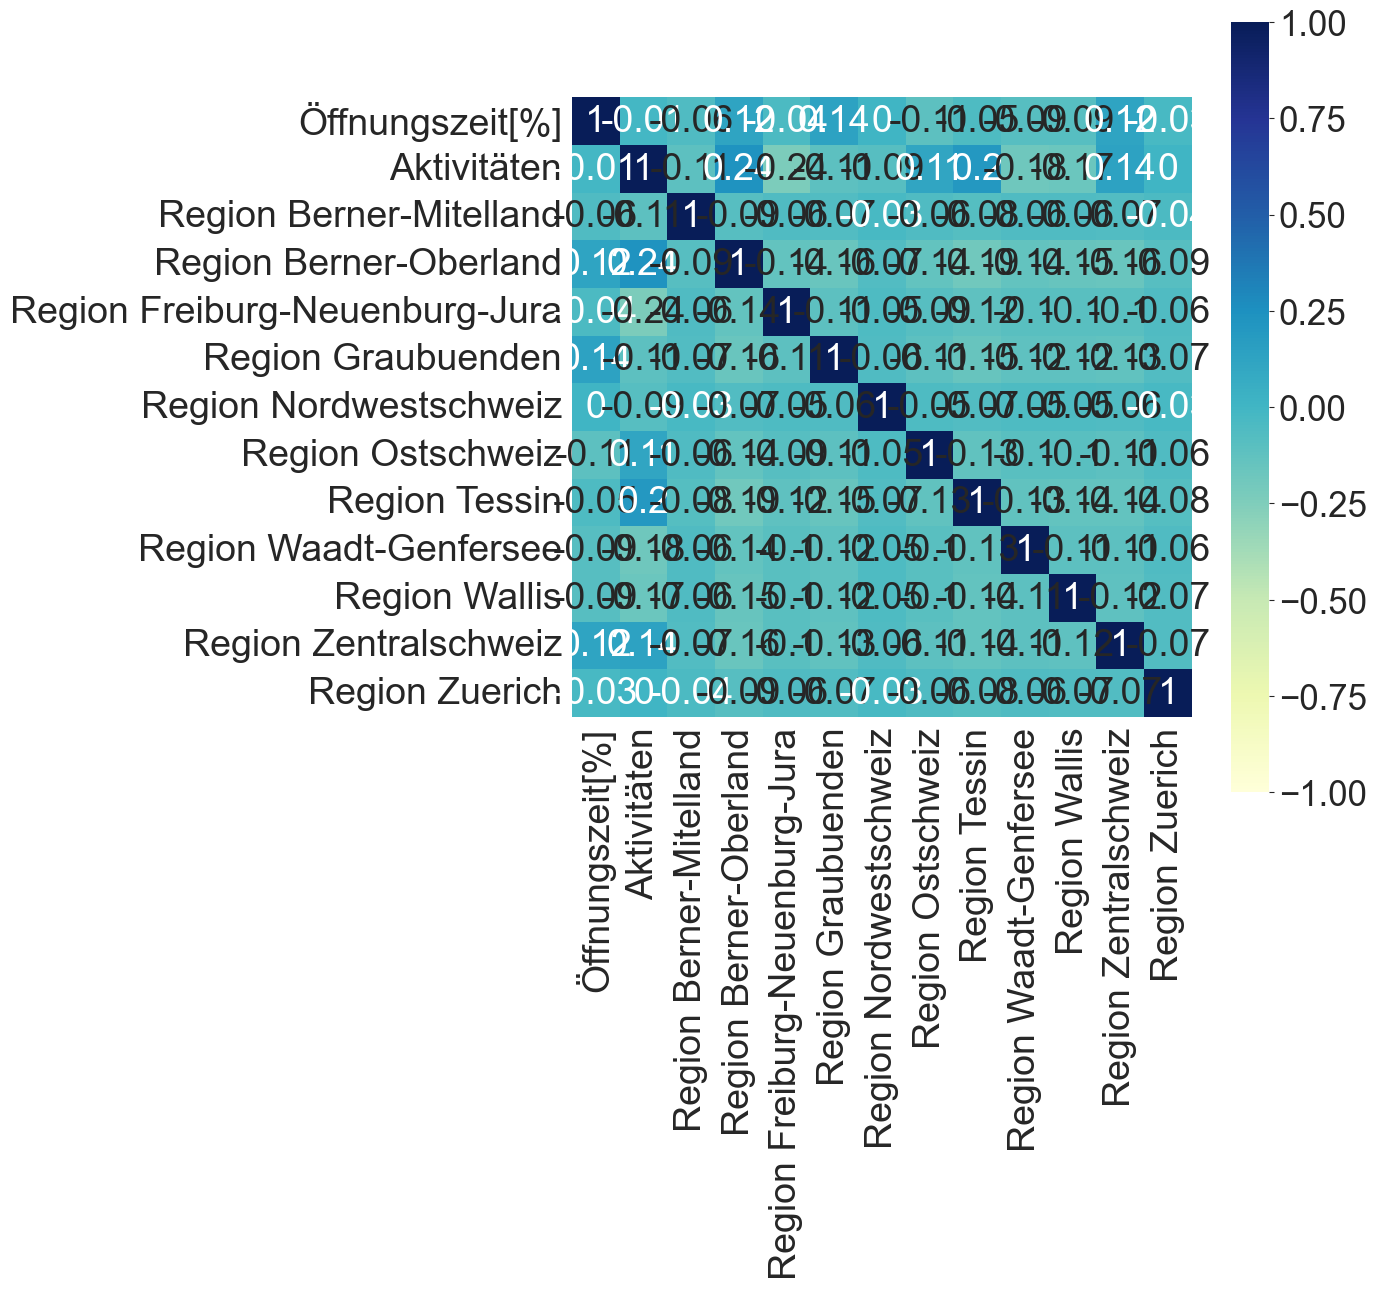

### Train-Test-Split
die Aufteilung von Training- und Testdaten sollte immer vor der Standardisierung oder jeglicher anderen Form der Datenvorverarbeitung durchgeführt werden:
Vermeidung von Datenlecks: Wenn du die Standardisierung vor der Aufteilung durchführst, wird die Information aus den Testdaten in die Standardisierungsparameter (Mittelwert und Standardabweichung) einbezogen, was zu Datenlecks führt. Das Modell erhält somit indirekt Informationen über die Testdaten, was zu unrealistisch guten Ergebnissen führt.

Replizierbarkeit: Wenn die Standardisierung nach der Aufteilung durchgeführt wird, ist der Prozess besser replizierbar und die Ergebnisse sind realistisch, da die Standardisierung nur auf Basis der Trainingsdaten erfolgt und auf die Testdaten angewendet wird.

In [ ]:
X = df_correlation.drop(['Preis'],axis = 1)
y = df_correlation['Preis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)